# Assessment 1 for PDS 2024

## Step 0 - getting the data

In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd

first_time = True
if first_time:
    driver = webdriver.Chrome()
    driver.get("https://en.wikipedia.org/wiki/Gun_death_and_violence_in_the_United_States_by_state")


    table = driver.find_element(By.XPATH, "//table[contains(@class, 'wikitable')]")
    headers = [
        'Location',
        'Gun suicide rate',
        'Suicide rate',
        'Gun homicide rate',
        'Homicide rate',
        '% Gun at home']

    # Extract rows
    data = []
    for row in table.find_elements(By.TAG_NAME, "tr")[1:]:
        cells = row.find_elements(By.TAG_NAME, "td")
        if cells:
            data.append([cell.text.strip() for cell in cells])
    df_gun = pd.DataFrame(data, columns=headers)

    driver.quit()


In [5]:
## bit of an ugly clean up job, but I had issues with doing it more elegantly
import numpy as np
df_gun.to_csv("wikipedia_table.csv", index=False)
df_gun["% Gun at home"] = df_gun["% Gun at home"].replace(["[a]", "[d]"], np.nan)
df_gun["Gun homicide rate"] = df_gun["Gun homicide rate"].replace(["[c]", "[b]"], np.nan)
df_gun = df_gun.dropna()
df_gun[["% Gun at home", "Gun homicide rate"]] = df_gun[["% Gun at home", "Gun homicide rate"]].replace("%", "", regex=True).astype(float)

##Some  of the columns werent numeric
for col in df_gun.columns[1:]:
    df_gun[col] = pd.to_numeric(df_gun[col], errors='coerce')

df_gun.head()

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home
1,Wyoming,23.7,32.8,1.7,2.8,61.0
2,Montana,21.6,31.7,2.7,4.2,65.0
3,Alaska,19.4,30.0,4.2,6.7,57.0
4,New Mexico,14.4,25.2,10.9,14.5,36.0
5,Oklahoma,13.8,22.0,6.4,8.6,55.0


## Exercise 1

### 1a)
Make histograms of each of the variables. Calculate the mean and median of
the gun homicide rate for all the states. Which state has the minimum, while
still having some data?

In [6]:
min_homicide_rate = df_gun["Gun homicide rate"].min()
min_rows = df_gun.loc[df_gun["Gun homicide rate"] == min_homicide_rate].Location.values[0]
print(f"{min_rows} has the minimum gun homicide rate of {min_homicide_rate}")

median =df_gun["Gun homicide rate"].median()
mean =df_gun["Gun homicide rate"].mean()

print(f"The median is {median}, and the mean is {mean}")


Maine has the minimum gun homicide rate of 0.9
The median is 5.1, and the mean is 6.056250000000001


### making the histograms (With estimated kernel density for the distribution estimation)

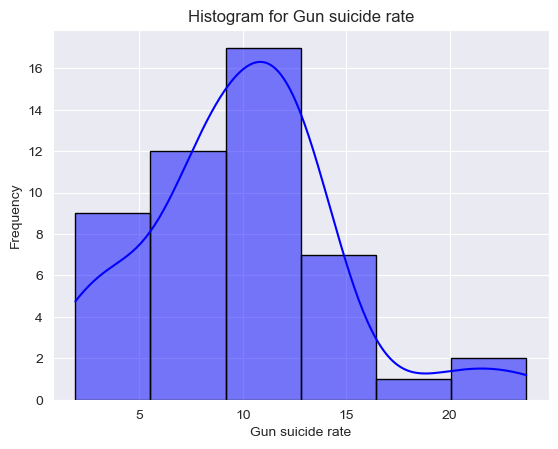

Gun suicide rate


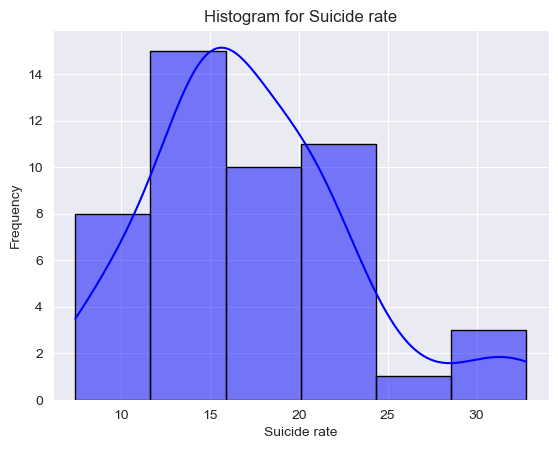

Suicide rate


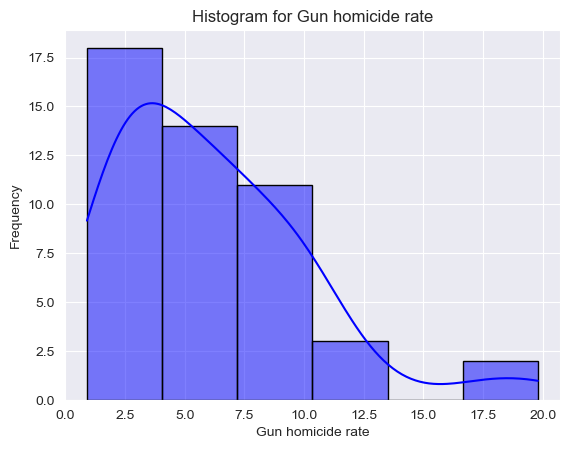

Gun homicide rate


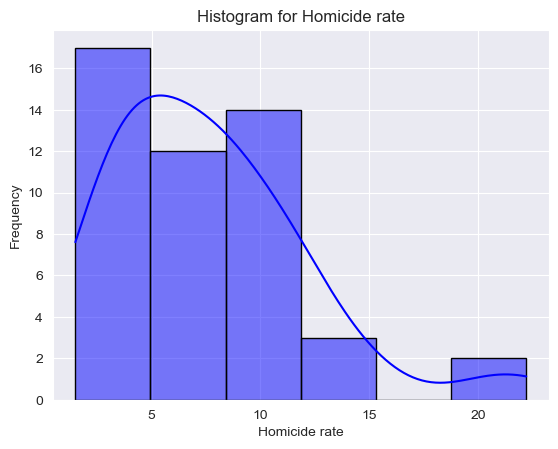

Homicide rate


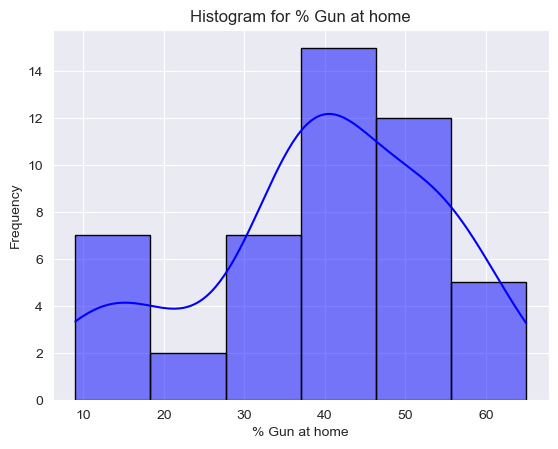

% Gun at home


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sturge's rule for the optimal bin amount is best for small datasets
# https://www.statology.org/sturges-rule/
opt_bin_size = int(np.log2(52)+1)

for col in df_gun.columns[1::]:
    plt.figure()
    sns.histplot(df_gun[col], bins=opt_bin_size, kde=True, color="blue", edgecolor="black")
    plt.title(f"Histogram for {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    print(col)


## 1b)
What is the odds ratio between homicide rate in the USA vs the Netherlands?
You will need to look up and cite where you find the gun homicide rate for
both. Interpret this value. Could you have used the mean from all the states?

The formular for the Odds ratio:

$OR = (A/B)/(C/D)$

A = Gun homicides total NE — 85 [3] <br>
B = Inhabitants NE — 18,300,040 [4]

C = Gun homicides total USA — 20,958[1]<br>
D= Inhabitants USA — 346,543,400 [2]

1. https://en.wikipedia.org/wiki/Gun_violence_in_the_United_States#:~:text=In%202021%2C%20a%20little%20above,the%20highest%20percentage%20since%202001.
2. https://www.worldometers.info/world-population/us-population/
3. https://worldpopulationreview.com/country-rankings/gun-deaths-by-country
4. https://www.worldometers.info/world-population/netherlands-population/#google_vignette




In [8]:
A = 85
B =18300040
C =20958
D =346543400

## we dont subtract the gun homicides here, as they would not make a significant difference from the population
OR = (A/B)/(C/D)

OR

0.07680238075690325

### What does that tell us?

As the OR = 0.0768 that mean 1—OR= 0.923, which can be intepreted as a 92% reduction in risk, but as this alone doesnt tell us a bunch we would also have to take a look at the absolute risks as well the Odds ratio

_*Could we have used the mean from all of the states?*_ <br>
We could have, but as the mean is quite susceptible to outliers this may have skewed the results


## 1c)


In [9]:
df_gun["Gun Homicide odds"] = (df_gun["Gun homicide rate"]/100000)/(1-(df_gun["Gun homicide rate"]/100000))
## for the highest as best ist ambiguous
df_gun_odds = df_gun.sort_values(by='Gun Homicide odds', ascending=False, inplace=False).head()
df_gun_odds

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home,Gun Homicide odds
21,Mississippi,11.3,16.3,19.8,22.2,54.0,0.000198
27,Louisiana,10.0,14.9,17.4,20.4,52.0,0.000174
12,Alabama,12.4,16.4,12.9,14.8,53.0,0.000129
4,New Mexico,14.4,25.2,10.9,14.5,36.0,0.000109
24,South Carolina,10.5,15.5,10.7,12.6,45.0,0.000107


In [10]:
## for the lowest
df_gun_odds = df_gun.sort_values(by='Gun Homicide odds', ascending=True, inplace=False).head()
df_gun_odds

,Location,Gun suicide rate,Suicide rate,Gun homicide rate,Homicide rate,% Gun at home,Gun Homicide odds
19,Maine,11.5,20.2,0.9,1.5,48.0,0.000009
50,Massachusetts,1.9,8.6,1.4,2.3,9.0,0.000014
6,Idaho,13.8,20.4,1.5,2.2,58.0,0.000015
47,Hawaii,2.9,14.0,1.6,2.7,9.0,0.000016
1,Wyoming,23.7,32.8,1.7,2.8,61.0,0.000017


___
___

## Exercise 2

### 2a)
Generate the mean and standard deviation for the Netherlands for life
expectancy and infant mortality from 2000 to 2015

In [11]:
df_Gap = pd.read_csv("Gapminder_1900-2017_by_yr.csv")
df_ndl = df_Gap[(df_Gap["country"] == "Netherlands") & (df_Gap["year"] >= 2000) & (df_Gap["year"] <= 2015)]

In [16]:
mean_infant = df_ndl["infant.mortality_per1000"].mean()
mean_infant

4.106249999999999

In [13]:
std_infant = df_ndl["infant.mortality_per1000"].std()
std_infant

0.6444312738117748

In [14]:
mean_life_exp = df_ndl["life.expectancy"].mean()
mean_life_exp

79.981875

In [15]:
std_life_exp = df_ndl["life.expectancy"].std()
std_life_exp

1.2077870604263552

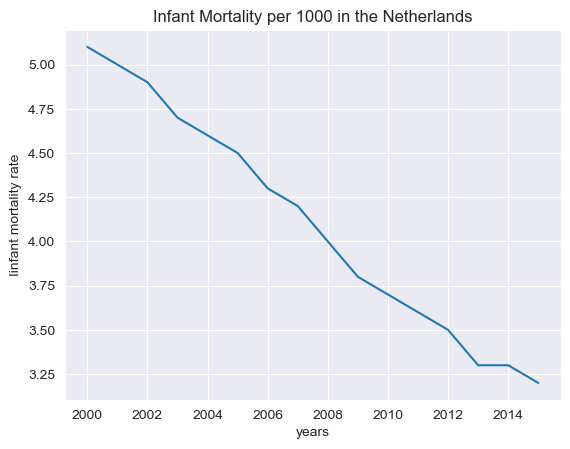

In [20]:
plt.figure()
sns.lineplot(y= df_ndl["infant.mortality_per1000"], x= range(2000,2016) )
plt.title(f"Infant Mortality per 1000 in the Netherlands")
plt.xlabel("years")
plt.ylabel("Iinfant mortality rate")
plt.grid(True)
plt.show()